In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from copy import deepcopy
import pygraphviz
import matplotlib.pyplot as plt
from networkx import nx_agraph

In [7]:
import sys
sys.path.append("../src/")
sys.path.append("..")

from sequential_causal_functions import (extract_data_streams_from_multivariate_time_series_list,
                                                     sequentially_sample_model,
                                                     powerset)
from sequential_intervention_functions import (create_n_dimensional_intervention_grid,
                                               get_interventional_grids,
                                               make_sequential_intervention_dictionary)

from experiments import optimal_sequence_of_interventions, optimise_one_time_step

from utilities import (initialise_DCBO_parameters_and_objects_filtering,
                       initialise_global_target_dict,
                       get_monte_carlo_expectation,
                       find_global_optima_at_current_time,convert_to_dict_of_temporal_lists)

from graph_functions import make_graphical_model
from src.experiments import optimal_sequence_of_interventions
from sequential_causal_functions import sequential_sample_from_model
from experiments import simulate_interventional_data_for_sequential_LinearToyDBN
from numpy.random import seed

In [8]:
from sem_estimate import make_sem_hat, make_sem_independent_hat
from dcbo_base import BaseClassDCBO
from dcbo import DCBO
from cbo import CBO
from abo import ABO
from bo import BO

from utilities import get_cumulative_cost_mean_and_std, extract_relevant_data_for_plotting
from plotting import plot_expected_opt_curve, plot_opt_curve, plot_average_curve
from experiments import run_methods_replicates
import pickle
from utilities import calculate_best_intervention_and_effect

---

# Stationary problems

## Independent

In [7]:
from structural_equation_models import NonStationaryIndependentSEM

SEM = NonStationaryIndependentSEM(change_point=1)
initial_structural_equation_model = SEM.static()
structural_equation_model = SEM.dynamic()

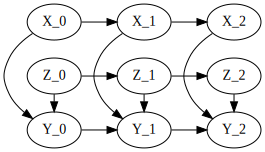

In [8]:
T = 3 # Required timesteps
graph_view = generate_CGM(0,T-1,spatial_connection_topo='independent',verbose=True) # Base topology
Graph = nx_agraph.from_agraph(pygraphviz.AGraph(graph_view.source))

# Non-Stationary problems

In [9]:
from structural_equation_models import NonStationarySEM

### Dependent

In [10]:
# Convert DOT string to NetworkX object
Graph = nx_agraph.from_agraph(pygraphviz.AGraph(graph_view.source))
# 1
# Graph.remove_edge('X_{}'.format(1),'Y_{}'.format(1),)
Graph.add_edge('Z_{}'.format(0),'Y_{}'.format(1),)
# 2
# Graph.remove_edge('Z_{}'.format(2),'Y_{}'.format(2),)
Graph.add_edge('X_{}'.format(1),'Y_{}'.format(2),)
Graph.add_edge('Z_{}'.format(1),'Y_{}'.format(2),)

0

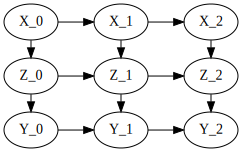

In [11]:
### Dependent

from structural_equation_models import NonStationaryDependentSEM

SEM = NonStationaryDependentSEM(change_point=1)
initial_structural_equation_model = SEM.static()
structural_equation_model = SEM.dynamic()

T = 3 # Required timesteps
graph_view = make_graphical_model(0,T-1,topology='dependent',nodes=['X','Z','Y'],verbose=True) # Base topology
graph_view

In [12]:
# Convert DOT string to NetworkX object
Graph = nx_agraph.from_agraph(pygraphviz.AGraph(graph_view.source))
Graph.add_edge('X_{}'.format(0),'Z_{}'.format(1),)
# Graph.add_edge('X_{}'.format(1),'Z_{}'.format(2),)
Graph.add_edge('Z_{}'.format(1),'Y_{}'.format(2),)
# Graph.add_edge('Z_{}'.format(3),'Y_{}'.format(4),)
# Graph.add_edge('X_{}'.format(1),'Y_{}'.format(2),)

0

In [10]:
# Number of independent samples per time-index
observational_samples = sequentially_sample_model(initial_structural_equation_model,
                                                  structural_equation_model,
                                                  total_timesteps=3,
                                                  sample_count=5,
                                                  epsilon=None)

s ('X',)
s ('Z',)
s ('X', 'Z')
t == 0
X [1.0, None, None]
Y [None, None, None]
Z [3.0, None, None]


t == 1
X [-4.0, 1.0, None]
Y [None, None, None]
Z [None, 3.0, None]


t == 2
X [-4.0, -0.11111111111111116, 1.0]
Y [None, None, None]
Z [None, None, 3.0]




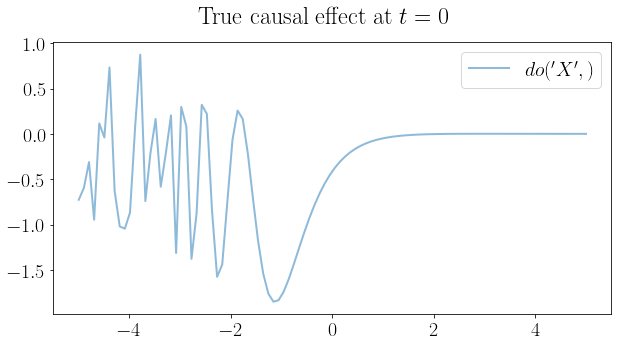

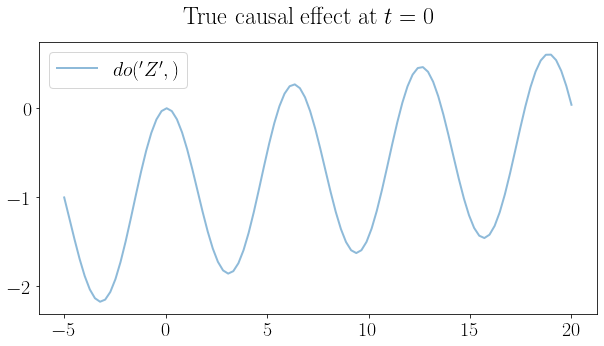

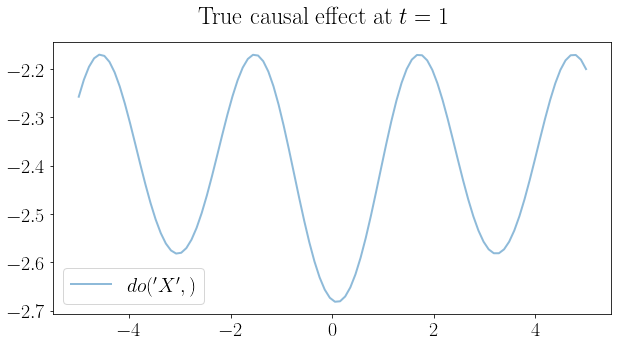

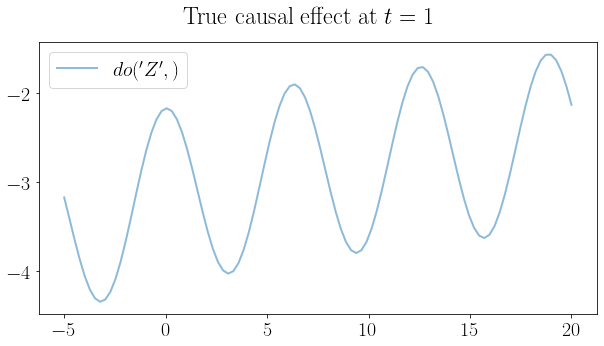

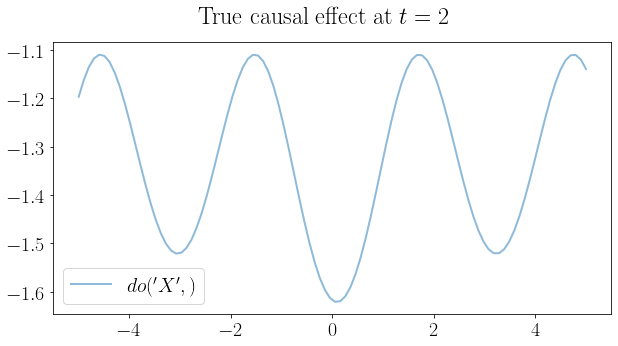

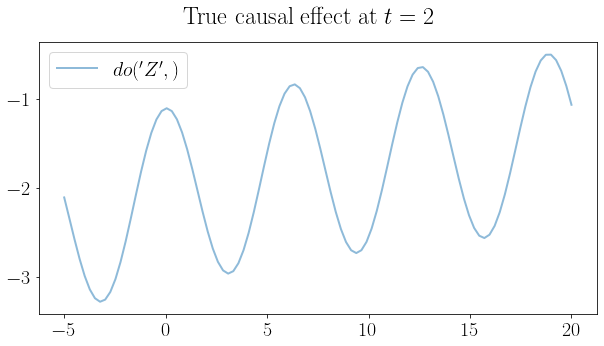

In [13]:
intervention_domain = {'X':[-4,1],'Z':[-3,3]}

N = 10
seed(seed=0)
epsilon_list = []
new_mean = 2.
new_std = 4.
for i in range(N):
    epsilon = {k: (np.random.randn(T)+new_mean)*new_std for k in initial_structural_equation_model.keys()}
    epsilon['Y'] = np.asarray(np.random.randn(T))
    epsilon_list.append(epsilon)
    

epsilon_list = None

seed(seed=0)
# Number of independent samples per time-index
observational_samples = sequentially_sample_model(initial_structural_equation_model,
                                                  structural_equation_model,
                                                  total_timesteps=T,
                                                  sample_count=N,
                                                  epsilon=epsilon_list)

exploration_sets = list(powerset(['X','Z']))  #[('X',),('Z',)] #list(powerset(['X','Z'])) 
# exploration_sets = [('X',),('Z',)]
interventional_grids = get_interventional_grids(exploration_sets, intervention_domain, size_intervention_grid=100)

interventional_data = simulate_interventional_data_for_sequential_LinearToyDBN(
    Graph, intervention_domain, initial_structural_equation_model, structural_equation_model
)

best_s_values, best_s_sequence, best_objective_values, y_stars_all, optimal_interventions, all_CE = \
optimal_sequence_of_interventions(exploration_sets, 
                                  interventional_grids, 
                                  initial_structural_equation_model,structural_equation_model,Graph,T=T)



GT = []
optimal_assigned_blankets = [None]*T

blanket, _ = make_sequential_intervention_dictionary(Graph)
for t in range(T):
    new_blanket, true_causal_effect  = calculate_best_intervention_and_effect(
                                          static_sem=initial_structural_equation_model,
                                          dynamic_sem=structural_equation_model,
                                          exploration_sets=exploration_sets,
                                          interventional_grids=interventional_grids,
                                          time=t,
                                          intervention_domain=intervention_domain,
                                          blanket=deepcopy(blanket),
                                          T=T,
                                          plot = True)
    if t < T-1: 
        optimal_assigned_blankets[t+1] = new_blanket
    
    blanket = new_blanket
    
    GT.append(true_causal_effect)

In [11]:
y_stars = [min([min(all_CE[t][es]) for es in exploration_sets]) for t in range(T)]
y_stars

[4.3166247903554, -8.329075657669375, 12.387156465750184]

In [12]:
best_s_sequence

[('X',), ('X',), ('Z',)]

In [13]:
optimal_assigned_blankets

[None,
 {'X': [-4.0, None, None],
  'Y': [4.3166247903554, None, None],
  'Z': [None, None, None]},
 {'X': [-4.0, -0.11111111111111116, None],
  'Y': [4.3166247903554, -8.329075657669375, None],
  'Z': [None, None, None]}]

## Conditionals

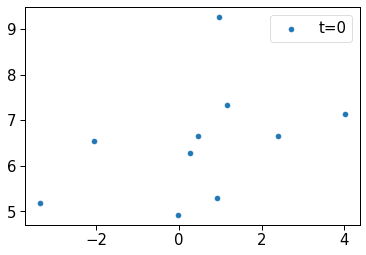

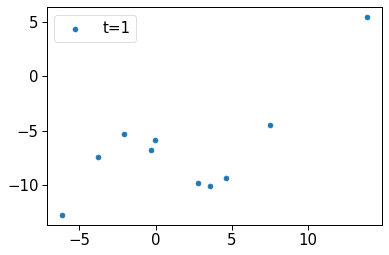

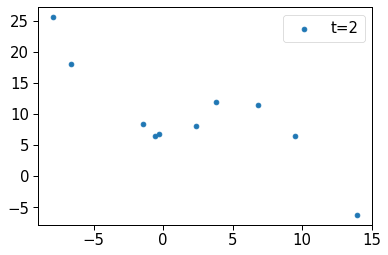

In [14]:
for t in range(T):
    plt.figure()
    plt.scatter(observational_samples['Z'][:,t],observational_samples['Y'][:,t],label="t={}".format(t))
    plt.legend()

# Non-stationary DCBO

In [15]:
np.set_printoptions(suppress=True) # Suppress scientific notation

In [92]:
change_points = T*[False]
change_points[1] = True

DCBO_input_params = {
    "graph": Graph,
    "sem": NonStationaryDependentSEM,
    "make_sem_hat": make_sem_hat,
    "observational_samples": observational_samples,
    "intervention_domain": intervention_domain,
    "interventional_samples": None,  
    "exploration_sets": exploration_sets[:-1],
    "number_of_trials": 30,
    "ground_truth": GT,
    "debug_mode": False,
    "optimal_assigned_blankets": None, #optimal_assigned_blankets,
    "transfer_hp_i": False,
    "transfer_hp_o": False,
    "use_di": False,
    "n_obs_t": None, #[10, 10, 10,1,1,1], # 
    "num_anchor_points": 100,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": change_points
}

In [93]:
dcbo = DCBO(**DCBO_input_params)
dcbo.run_optimization()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = 4.709725935236852
Optimization restart 1/1, f = 5.671133447774524
Optimization restart 1/1, f = 5.944357316009758
Optimization restart 1/1, f = 7.140823976520185
Optimization restart 1/1, f = 3.6805467531671114
Optimization restart 1/1, f = 5.999753638844172
Optimization restart 1/1, f = 5.276148711391125
Optimization restart 1/1, f = -0.9522503473606976
Optimization restart 1/1, f = -1.7334517717397122
Optimization restart 1/1, f = -6.303083139559766
Optimization restart 1/1, f = -10.431783151312022
Optimization restart 1/1, f = -14.742019850998386
Optimization restart 1/1, f = -19.38640185912847
Optimization restart 1/1, f = -21.665065687372405
Optimization restart 1/1, f = -25.782368162867485
Optimization restart 1/1, f = -26.1548499426767
Optimization restart 1/1, f = -30.870375014636604
Optimization

In [14]:
y_stars

[-2.171295791504807, -4.342591583009614, -3.281564142191188]

In [64]:
dcbo.assigned_blanket_hat

{'X': [-3.9999398321525748, None, None],
 'Y': [4.316715495012209, -7.31590986718501, 4.319102087182774],
 'Z': [None, 2.9992037557432756, 0.0023959757410398907]}

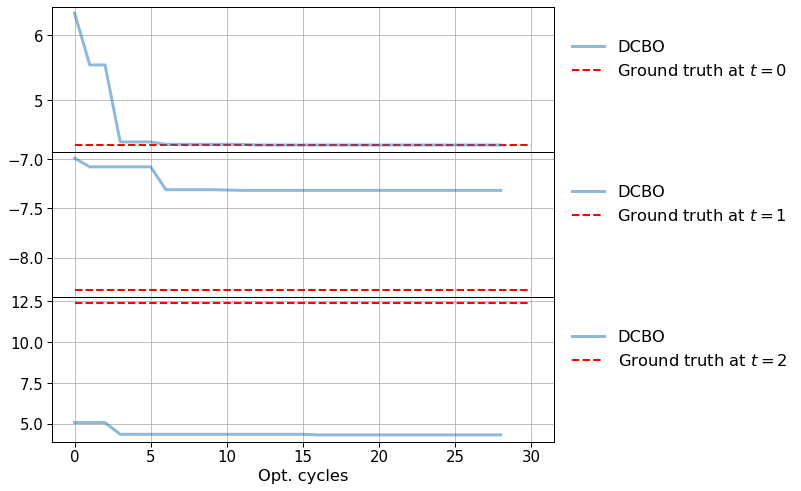

In [96]:
fig, ax = plt.subplots(T, figsize=(9,8), sharex=True)
for i in range(T):
    ax[i].plot(dcbo.optimal_outcome_values_during_trials[i][1:],lw=3,label='DCBO',alpha=0.5)
    ax[i].hlines(y_stars[i],0,DCBO_input_params["number_of_trials"],
                 'r',ls='--',lw=2,alpha=1,label='Ground truth at $t={}$'.format(i))
    ax[i].grid(True)
    ax[i].legend(ncol=1, fontsize="medium", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.4))

ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

# CBO

In [23]:
from cbo import CBO

In [89]:
change_points = T*[False]
change_points[1] = True

CBO_input_params = {
    "graph": Graph, 
    "sem": NonStationaryDependentSEM,
    "make_sem_hat": make_sem_hat,
    "observational_samples": observational_samples,
    "intervention_domain": intervention_domain,
    "exploration_sets": exploration_sets[:-1],
    "interventional_samples": None,   
    "number_of_trials": 10, 
    "ground_truth": GT,
    "debug_mode": False,
    "optimal_assigned_blankets": None, # optimal_assigned_blankets,
    "n_obs_t": None,
    "num_anchor_points": 100,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points" : change_points
}

In [90]:
%%time
cbo = CBO(**CBO_input_params)
cbo.run_optimization()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 ../src/structural_equation_models.py:158: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = 4.709725935236852
Optimization restart 1/1, f = 5.671133447774524
Optimization restart 1/1, f = 5.944357316009758
Optimization restart 1/1, f = 7.140823976520185
Optimization restart 1/1, f = 3.6805467531671114
Optimization restart 1/1, f = 5.999753638844172
Time index:  33%|███▎      | 1/3 [00:03<00:06,  3.22s/it]Optimization restart 1/1, f = 5.276148711391125
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = 5.165507102269893
Optimization restart 1/1, f = 7.374574280927735
Optimization restart 1/1, f = 7.07315926523615
Optimization restart 1/1, f = 5.473138259438511
Optimization restart 1/1, f = 9.538181483216274
Opti

# Plot DCBO vs CBO

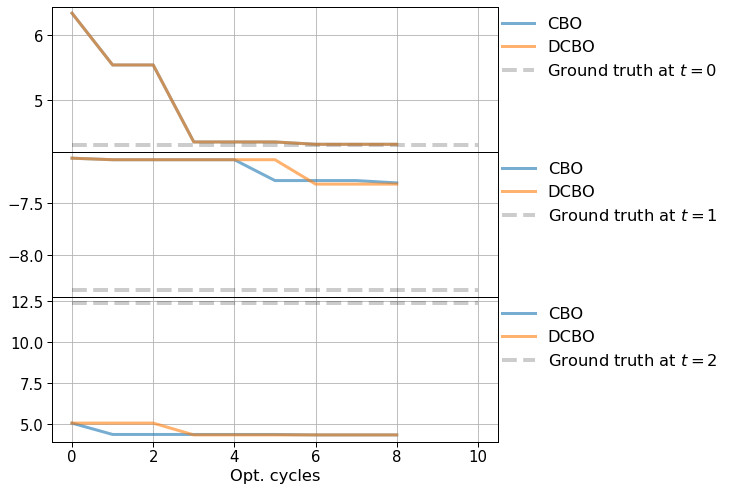

In [91]:
fig, ax = plt.subplots(T, figsize=(8,8), sharex=True)
for i in range(T):
    ax[i].plot(cbo.optimal_outcome_values_during_trials[i][1:],alpha=0.6,lw=3,label='CBO')
    ax[i].plot(dcbo.optimal_outcome_values_during_trials[i][1:],alpha=0.6,lw=3,label='DCBO')
    ax[i].hlines(best_objective_values[i],0,CBO_input_params["number_of_trials"],
                 'k',ls='--',lw=4,alpha=0.2,label='Ground truth at $t={}$'.format(i))
    ax[i].grid(True)
    ax[i].legend(ncol=1, fontsize="medium", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.4))
ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

# ABO

In [47]:
from abo import ABO

In [53]:
ABO_input_params = {
    "graph": Graph,
    "sem": NonStationaryDependentSEM,
    "observational_samples": observational_samples,
    "intervention_domain":intervention_domain,
    "interventional_samples": None,   
    "number_of_trials": 30,
    "optimal_assigned_blankets": None, #optimal_assigned_blankets,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": change_points
}

In [54]:
abo = ABO(**ABO_input_params)
abo.run_optimization()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = 9.502633635868555
Optimization restart 1/1, f = 9.35001468514117
Optimization restart 1/1, f = 5.789131830120601
Optimization restart 1/1, f = 8.044689263410058
Optimization restart 1/1, f = 7.1861577948127
Optimization restart 1/1, f = 6.687335022647204
Optimization restart 1/1, f = 4.946682295422846
Optimization restart 1/1, f = 3.7839744418375627
Optimization restart 1/1, f = 0.0950918391701272
Optimization restart 1/1, f = -2.9310576409157756
Optimization restart 1/1, f = -5.776913505746349
Optimization restart 1/1, f = -8.26963293852467
Optimization restart 1/1, f = -12.80072607245536
Optimization restart 1/1, f = -17.355626142990424
Optimization restart 1/1, f = -18.190861705906595
Time index:  33%|███▎      | 1/3 [00:00<00:01,  1.93it/s]reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = -20.828831260980945
Optimizatio

## Plot convergence 

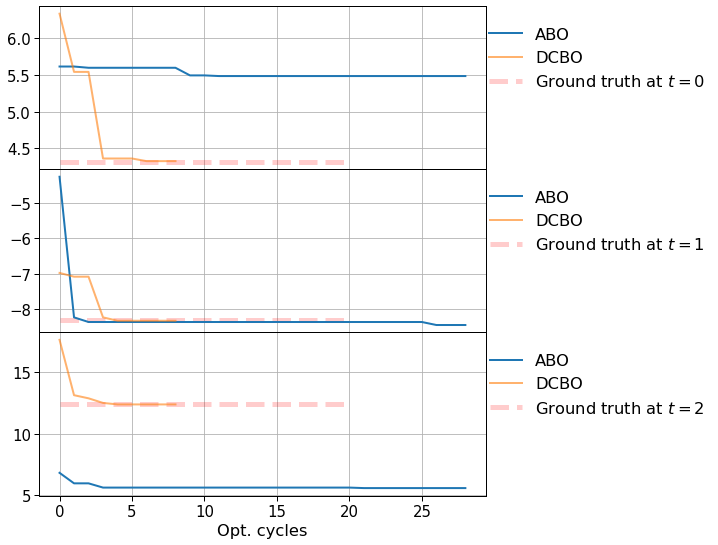

In [55]:
fig, ax = plt.subplots(T, figsize=(8,9), sharex=True)
for i in range(T):
    ax[i].plot(abo.optimal_outcome_values_during_trials[i][1:],lw=2,label='ABO')
    # ax[i].plot(cbo.optimal_outcome_values_during_trials[i][1:],lw=2,label='CBO')
    ax[i].plot(dcbo.optimal_outcome_values_during_trials[i][1:],lw=2,alpha=0.6,label='DCBO')
    ax[i].hlines(best_objective_values[i],0,20,'r',ls='--',lw=5,alpha=0.2,label='Ground truth at $t={}$'.format(i))
    ax[i].grid(True)
    ax[i].legend(ncol=1, fontsize="medium", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.4))
ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

# BO 

In [56]:
from bo import BO

In [63]:
BO_input_params = {
    "graph": Graph,
    "sem":NonStationaryDependentSEM,
    "observational_samples": observational_samples,
    "intervention_domain": intervention_domain,
    "interventional_samples":None,   
    "number_of_trials": 30,
    "optimal_assigned_blankets": None, #optimal_assigned_blankets,
    "sample_anchor_points": True,
    "seed_anchor_points": 1,
    "change_points": change_points
}

In [64]:
bo = BO(**BO_input_params)
bo.run_optimization()

Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
Time: 0
Optimization restart 1/1, f = 9.502633635868555
Optimization restart 1/1, f = 9.35001468514117
Optimization restart 1/1, f = 5.789131830120601
Optimization restart 1/1, f = 8.044689263410058
Optimization restart 1/1, f = 7.1861577948127
Optimization restart 1/1, f = 6.687335022647204
Optimization restart 1/1, f = 4.946682295422846
Optimization restart 1/1, f = 3.7839744418375627
Optimization restart 1/1, f = 0.0950918391701272
Optimization restart 1/1, f = -2.9310576409157756
Optimization restart 1/1, f = -5.776913505746349
Optimization restart 1/1, f = -8.26963293852467
Optimization restart 1/1, f = -12.80072607245536
Optimization restart 1/1, f = -17.355626142990424
Optimization restart 1/1, f = -18.190861705906595
Optimization restart 1/1, f = -20.828831260980945
Optimization restart 1/1, f = -17.87115425090592
Optimization restart 1/1, f = -22.291559851123097
Optimization r

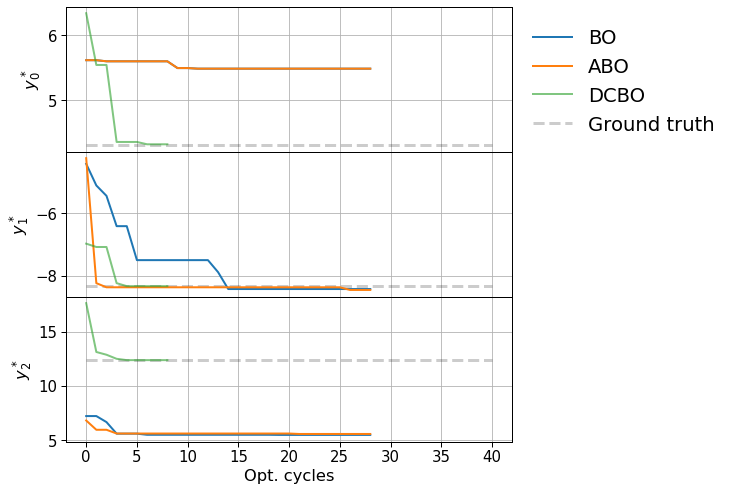

In [65]:
fig, ax = plt.subplots(T, figsize=(8,8), sharex=True)
for i in range(T):
    ax[i].plot(bo.optimal_outcome_values_during_trials[i][1:],lw=2,label='BO')
    ax[i].plot(abo.optimal_outcome_values_during_trials[i][1:],lw=2,label='ABO')
    # ax[i].plot(cbo.optimal_outcome_values_during_trials[i][1:],lw=2,label='CBO')
    ax[i].plot(dcbo.optimal_outcome_values_during_trials[i][1:],lw=2,alpha=0.6,label='DCBO')
    ax[i].hlines(best_objective_values[i],0,40,'k',ls='--',lw=3,alpha=0.2,label='Ground truth')
    ax[i].set_ylabel(r"$y^*_{}$".format(i))
    ax[i].grid(True)
    if i == 0:
        ax[i].legend(ncol=1, fontsize="large", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.))
ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

# All methods convergence plot

In [ ]:
fig, ax = plt.subplots(T, figsize=(10,10), sharex=True)
for i in range(T):
    ax[i].plot(([0] + list(np.cumsum(bo.per_trial_cost[i])))[:2], 
               bo.optimal_outcome_values_during_trials[i][1:],lw=2,label='BO')
    
    ax[i].plot(([0] + list(np.cumsum(abo.per_trial_cost[i])))[:2], 
               abo.optimal_outcome_values_during_trials[i][1:],lw=2,label='ABO')
    ax[i].plot(dcbo.optimal_outcome_values_during_trials[i][1:],lw=3,label='DCBO')
    ax[i].plot(cbo.optimal_outcome_values_during_trials[i][1:],lw=2,label='CBO')
    ax[i].hlines(best_objective_values[i],0,5,'r',ls='--',lw=5,alpha=0.2,label='Ground truth at $t={}$'.format(i))
    ax[i].grid(True)
    if i == 0:
        ax[i].legend(ncol=1, fontsize="medium", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.0))
ax[2].set_xlabel(r"Opt. cycles")

plt.subplots_adjust(hspace=0)
plt.show()

## Verify with replicate run

In [ ]:
dcbo_r = results['DCBO'][0]
cbo_r = results['CBO'][0]
abo_r = results['ABO'][0]
bo_r = results['BO'][0]

In [ ]:
bo_r.optimal_intervention_sets

In [ ]:
fig, ax = plt.subplots(T, figsize=(10,10), sharex=True)
for i in range(T):
    ax[i].plot(list(np.cumsum(bo_r.per_trial_cost[i]))[1:], 
               bo_r.optimal_outcome_values_during_trials[i][1:],lw=2,label='BO')
    ax[i].plot(list(np.cumsum(abo_r.per_trial_cost[i]))[1:], 
               abo_r.optimal_outcome_values_during_trials[i][1:],lw=2,label='ABO')
    ax[i].plot(dcbo_r.optimal_outcome_values_during_trials[i][1:],lw=3,label='DCBO')
    ax[i].plot(cbo_r.optimal_outcome_values_during_trials[i][1:],lw=2,label='CBO')
    ax[i].hlines(best_objective_values[i],0,40,'r',ls='--',lw=5,alpha=0.2,label='Ground truth at $t={}$'.format(i))
    ax[i].grid(True)
    if i == 0:
        ax[i].legend(ncol=1, fontsize="medium", loc="lower center", frameon=False, bbox_to_anchor=(1.25, 0.0))
ax[2].set_xlabel(r"Cumulative cost")

plt.subplots_adjust(hspace=0)
plt.show()

# Run replicates 

In [100]:
from plotting import plot_expected_opt_curve, plot_opt_curve
from experiments import run_methods_replicates

In [104]:
print(exploration_sets,change_points,intervention_domain)

[('X',), ('Z',), ('X', 'Z')] [False, True, False] {'X': [-6.283185307179586, 3.141592653589793], 'Z': [-9.42477796076938, 0.0]}


In [111]:
y_stars

[-2.4833689141070905, -2.4275442087002332, 0.9758900265388032]

In [98]:
%%time
n_replicates = 10
n_trials = 15
number_of_interventions = None
folder = 'nonstat'
online = False
concat = False
n_obs = 10
sample_anchor_points = True
cost_list = [1]
n_obs_t = None, #[10, 10, 10, 1, 1, 1] #[10, 10, 10]
noise_experiment = False
for cost in cost_list:
    results = run_methods_replicates(graph=Graph, 
                                     sem=NonStationaryDependentSEM, 
                                     make_sem_hat = make_sem_hat, 
                                     intervention_domain = intervention_domain, 
                                     methods_list = ['DCBO', 'CBO', 'ABO', 'BO'],
                                     obs_samples = None, #observational_samples,
                                     exploration_sets = exploration_sets[:-1],
                                     ground_truth = GT,
                                     total_timesteps = T,
                                     reps = n_replicates,
                                     number_of_trials = n_trials, 
                                     n_restart = 1,
                                     save_data = True,
                                     n_obs = n_obs,
                                     online = False,
                                     concat = False,
                                     use_di = False, 
                                     transfer_hp_i = False,
                                     transfer_hp_o = False,
                                     hp_i_prior = True,
                                     debug_mode = False,
                                     folder = folder,
                                     optimal_assigned_blankets = None,# optimal_assigned_blankets,
                                     num_anchor_points = 100,
                                     n_obs_t = n_obs_t,
                                     sample_anchor_points = sample_anchor_points,
                                     controlled_experiment=True,
                                     noise_experiment=noise_experiment,
                                     change_points=change_points)

Experiment count:   0%|          | 0/10 [00:00<?, ?it/s]
	>>>DCBO


Time index:   0%|          | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 ../src/structural_equation_models.py:158: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
Optimization restart 1/1, f = 4.709725935236852
Optimization restart 1/1, f = 5.671133447774524
Optimization restart 1/1, f = 5.944357316009758
Optimization restart 1/1, f = 7.140823976520185
Optimization restart 1/1, f = 3.6805467531671114
Optimization restart 1/1, f = 5.999753638844172
Optimization restart 1/1, f = 5.276148711391125
Optimization restart 1/1, f = -0.9522503473606976
Optimization restart 1/1, f = -1.7334517717397122
Optimization restart 1/1, f = -6.303083139559766
Optimization restart 1/1, f = -10.431783151312022

Time index:  33%|███▎      | 1/3 [00:05<00:10,  5.45s/it]Optimization restart 1/1, f = -14.742019850998386
reconstraining parameters GP_re

In [97]:
print(y_stars,best_s_sequence)

[4.3166247903554, -8.329075657669375, 12.387156465750184] [('X',), ('X',), ('Z',)]
